## **Data Load**

In [1]:
# import all library

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import timeit
import tracemalloc

In [2]:
mat_content = sio.loadmat('assets/face.mat')
# mat_content # Let's see the content...

face_data = mat_content['X']
face_labels = mat_content['l']

x_train, x_test, y_train, y_test = [], [], [], []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class

    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train, x_test = np.hstack(x_train), np.hstack(x_test)
y_train, y_test = np.hstack(y_train), np.hstack(y_test)

x_train = x_train.astype(np.int64)
x_test = x_test.astype(np.int64)

# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


## **Q2. Incremental PCA**

creating subdatasets

In [3]:
x_sub1, x_sub2, x_sub3, x_sub4 = [], [], [], []
y_sub1, y_sub2, y_sub3, y_sub4 = [], [], [], []

n_classes = 52
images_per_class = 8

for i in range(n_classes):
  x_sub1.append(x_train[:,i*images_per_class :i*images_per_class + 2])
  x_sub2.append(x_train[:,i*images_per_class+2 :i*images_per_class + 4])
  x_sub3.append(x_train[:,i*images_per_class+4 :i*images_per_class + 6])
  x_sub4.append(x_train[:,i*images_per_class+6 :i*images_per_class + 8])

  y_sub1.append(y_train[:,i*images_per_class :i*images_per_class + 2])
  y_sub2.append(y_train[:,i*images_per_class+2 :i*images_per_class + 4])
  y_sub3.append(y_train[:,i*images_per_class+4 :i*images_per_class + 6])
  y_sub4.append(y_train[:,i*images_per_class+6 :i*images_per_class + 8])

x_sub1, x_sub2, x_sub3, x_sub4 = np.hstack(x_sub1), np.hstack(x_sub2), np.hstack(x_sub3), np.hstack(x_sub4)
y_sub1, y_sub2, y_sub3, y_sub4 = np.hstack(y_sub1), np.hstack(y_sub2), np.hstack(y_sub3), np.hstack(y_sub4)

x_subs = [x_sub1, x_sub2, x_sub3, x_sub4]
y_subs = [y_sub1, y_sub2, y_sub3, y_sub4]

1. Incremental learning

In [78]:
def ipca_nn(n_components, x_subs, y_subs, x_test):
  # Measure memory usage and execution time
  tracemalloc.start() 
  start_time = timeit.default_timer()  # Start timing

  ipca = IncrementalPCA(n_components = n_components)
  for subset in x_subs:
    ipca.partial_fit(subset.T)

  current_memory, peak_memory = tracemalloc.get_traced_memory()
  tracemalloc.stop()
  end_time = timeit.default_timer()  # Stop timing
  run_time = end_time - start_time
  
  # Project train data
  W_train_sub1 = ipca.transform(x_sub1.T).T
  W_train_sub2 = ipca.transform(x_sub2.T).T
  W_train_sub3 = ipca.transform(x_sub3.T).T
  W_train_sub4 = ipca.transform(x_sub4.T).T
  W_train = np.vstack((W_train_sub1.T, W_train_sub2.T, W_train_sub3.T, W_train_sub4.T))

  # Train NN model
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  y_train_combined = np.concatenate([y_subs[0].T, y_subs[1].T, y_subs[2].T, y_subs[3].T])
  nn.fit(W_train, y_train_combined.ravel())

  # Project test data and predict
  W_test = ipca.transform(x_test.T).T
  y_pred = nn.predict(W_test.T)

  return y_pred, run_time, current_memory, peak_memory

ipca_y_pred, ipca_run_time, ipca_current_memory, ipca_peak_memory = ipca_nn(15, x_subs, y_subs, x_test)

accuracy = accuracy_score(y_test.T, ipca_y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Current memory usage: {ipca_current_memory / 10**6} MB")
print(f"Peak memory usage: {ipca_peak_memory / 10**6} MB")
print(f"Execution Time: {ipca_run_time:.8f} seconds")

Accuracy: 51.92%
Current memory usage: 2.516909 MB
Peak memory usage: 12.607689 MB
Execution Time: 0.15951154 seconds


Define pca and nn classifier

In [79]:
def pca_nn(n_components, x_train, y_train, x_test):
  # Measure memory usage and execution time
  tracemalloc.start() 
  start_time = timeit.default_timer()

  pca = PCA(n_components = n_components)
  pca.fit(x_train.T)

  current_memory, peak_memory = tracemalloc.get_traced_memory()
  tracemalloc.stop()
  end_time = timeit.default_timer()

  run_time = end_time - start_time

  # Project train data
  W_train = pca.transform(x_train.T).T

  # Train NN model
  nn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
  nn.fit(W_train.T, y_train.reshape(-1))

  # Project test data and predict
  W_test = pca.transform(x_test.T).T
  y_pred = nn.predict(W_test.T)

  return y_pred, run_time, current_memory, peak_memory

2. Batch PCA

In [ ]:
batch_y_pred, batch_run_time, batch_current_memory, batch_peak_memory = pca_nn(15, x_train, y_train, x_test)

accuracy = accuracy_score(y_test.T, batch_y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Current memory usage: {batch_current_memory / 10**6} MB")
print(f"Peak memory usage: {batch_peak_memory / 10**6} MB")
print(f"Execution Time: {batch_run_time:.8f} seconds")

Accuracy : 49.04%
Current memory usage: 0.538973 MB
Peak memory usage: 10.249841 MB
Execution Time: 0.02991154 seconds


3. PCA with first train subset

In [75]:
# Input of pca_nn: x_sub1
sub1_y_pred, sub1_run_time, sub1_current_memory, sub1_peak_memory = pca_nn(5, x_sub1, y_sub1, x_test)

accuracy = accuracy_score(y_test.T, sub1_y_pred)
print(f"Accuracy : {accuracy * 100:.2f}%")
print(f"Current memory usage: {sub1_current_memory / 10**6} MB")
print(f"Peak memory usage: {sub1_peak_memory / 10**6} MB")
print(f"Execution Time: {sub1_run_time:.8f} seconds")

Accuracy : 17.31%
Current memory usage: 0.332429 MB
Peak memory usage: 3.135013 MB
Execution Time: 0.01594871 seconds


Show result

In [86]:
num_base_vecs = []

ipca_acc_result = []
batch_acc_result = []
sub1_acc_result = []

ipca_runtime_result = []
batch_runtime_result = []
sub1_runtime_result = []

ipca_cur_mem_result = []
batch_cur_mem_result = []
sub1_cur_mem_result = []

ipca_peak_mem_result = []
batch_peak_mem_result = []
sub1_peak_mem_result = []


for i in range(1, 21):
    num_bases = 5*i
    num_base_vecs.append(num_bases)
    
    # Get each PCA result
    ipca_y_pred, ipca_run_time, ipca_current_memory, ipca_peak_memory = ipca_nn(num_bases, x_subs, y_subs, x_test)
    batch_y_pred, batch_run_time, batch_current_memory, batch_peak_memory = pca_nn(num_bases, x_train, y_train, x_test)
    sub1_y_pred, sub1_run_time, sub1_current_memory, sub1_peak_memory = pca_nn(num_bases, x_sub1, y_sub1, x_test)
    
    # accuracy: %
    ipca_accuracy = accuracy_score(y_test.T, ipca_y_pred) * 100
    batch_accuracy = accuracy_score(y_test.T, batch_y_pred) * 100
    sub1_accuracy = accuracy_score(y_test.T, sub1_y_pred) * 100

    # accuracy arrays
    ipca_acc_result.append(ipca_accuracy)
    batch_acc_result.append(batch_accuracy)
    sub1_acc_result.append(sub1_accuracy)

    # runtime arrays -> seconds
    ipca_runtime_result.append(ipca_run_time)
    batch_runtime_result.append(batch_run_time)
    sub1_runtime_result.append(sub1_run_time)
    

    # peak memory arrays -> Mega Bite (MB)
    ipca_peak_mem_result.append(ipca_peak_memory / 10**6)
    batch_peak_mem_result.append(batch_peak_memory / 10**6)
    sub1_peak_mem_result.append(sub1_peak_memory / 10**6)

    ipca_cur_mem_result.append(ipca_current_memory / 10**6)
    batch_cur_mem_result.append(batch_current_memory / 10**6)
    sub1_cur_mem_result.append(sub1_current_memory / 10**6)


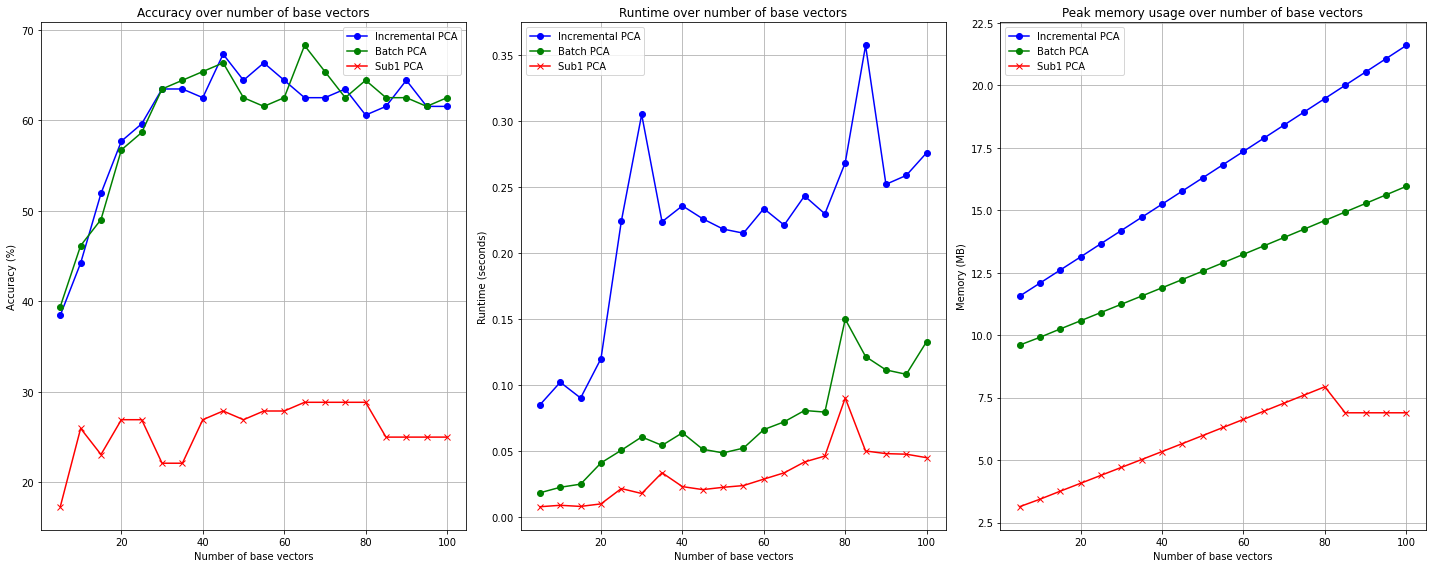

In [88]:
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot accuracy on the first subplot
axes[0].plot(num_base_vecs, ipca_acc_result, label='Incremental PCA', marker='o', linestyle='-', color='b')
axes[0].plot(num_base_vecs, batch_acc_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[0].plot(num_base_vecs, sub1_acc_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[0].set_xlabel('Number of base vectors')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('Accuracy over number of base vectors')
axes[0].legend()
axes[0].grid(True)

# Plot runtime on the second subplot
axes[1].plot(num_base_vecs, ipca_runtime_result, label='Incremental PCA', marker='o', linestyle='-', color='b')
axes[1].plot(num_base_vecs, batch_runtime_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[1].plot(num_base_vecs, sub1_runtime_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[1].set_xlabel('Number of base vectors')
axes[1].set_ylabel('Runtime (seconds)')  # Customize based on your runtime units
axes[1].set_title('Runtime over number of base vectors')
axes[1].legend()
axes[1].grid(True)

# Plot Peak memory usage on third subplot
axes[2].plot(num_base_vecs, ipca_peak_mem_result, label='Incremental PCA', marker='o', linestyle='-', color='b')
axes[2].plot(num_base_vecs, batch_peak_mem_result, label='Batch PCA', marker='o', linestyle='-', color='g')
axes[2].plot(num_base_vecs, sub1_peak_mem_result, label='Sub1 PCA', marker='x', linestyle='-', color='r')
axes[2].set_xlabel('Number of base vectors')
axes[2].set_ylabel('Memory (MB)')  # Customize based on your runtime units
axes[2].set_title('Peak memory usage over number of base vectors')
axes[2].legend()
axes[2].grid(True)

# Display the combined plot
plt.tight_layout()  # Adjust layout for better spacing
plt.show()